# Import the Dataset

The following imports the dataset from the hugging face repository "surrey-nlp/PLOD-CW". The dataset contains 3 dataset dictionaries - train, validation and test. Each dictionary item has Dataset definitions of "tokens", "pos_tags" and "ner_tags". These are represented as lists of lists of strings, the sublists being a representation of rows.

In [1]:
from datasets import load_dataset, DatasetDict, Dataset # Import dataset import function for hugging face
dataset_dict:DatasetDict = load_dataset("surrey-nlp/PLOD-CW") # import the coursework dataset from

In [2]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})

In [3]:
print(f"Type of the Overall Dataset:",type(dataset_dict))
print(f"Type of a Single Dataset:",type(dataset_dict["train"]))
print(f"Type of Single Dataset list:",type(dataset_dict["train"]["tokens"]))

Type of the Overall Dataset: <class 'datasets.dataset_dict.DatasetDict'>
Type of a Single Dataset: <class 'datasets.arrow_dataset.Dataset'>
Type of Single Dataset list: <class 'list'>


#### Dataset Manipulation Instructions

**Dataset** splits into 3 distinct parts:
- train
- validation
- test

To access each call `dataset[set_name]`

For instance `dataset["train"]`

Each set has 3 **features**:
- tokens (words that form a sentance, split into a list)
- pos_tags (part of speech tags)
- ner_tags (name entity recognition tags)

To access each features, call `dataset[set_name][feature_name]`

For instance `dataset["train"]["tokens"]`

First element `dataset["train"]["tokens"][0]`

In [4]:
# train dataset values
train_dataset:Dataset = dataset_dict["train"] # train dataset
train_tokens:list[list[str]] = train_dataset["tokens"] # train dataset tokens
train_pos_tags:list[list[str]] = train_dataset["pos_tags"] # train dataset pos tags
train_ner_tags:list[list[str]] = train_dataset["ner_tags"] # train dataset ner tags

# validation dataset values
validation_dataset= dataset_dict["validation"]
validation_tokens:list[list[str]] = validation_dataset["tokens"]
validation_pos_tags:list[list[str]] = validation_dataset["pos_tags"]
validation_ner_tags:list[list[str]] = validation_dataset["ner_tags"]

# test dataset values
test_dataset:Dataset = dataset_dict["test"]
test_tokens:list[list[str]] = test_dataset["tokens"]
test_pos_tags:list[list[str]] = test_dataset["pos_tags"]
test_ner_tags:list[list[str]] = test_dataset["ner_tags"]

#### List Manipulation

In order to test the dataset, we also need 2 utility functions we will be using: data_to_lower() and flatten_list().

The data_to_lower allows us to manipulate tokens to be lower cased so we would not have issues with upper or lower case words not being recognised. The flatten_list will allow us to take the rows of a list (list of lists) and make it into a single large list that we can iterate over. This will become useful when we want to access all values together.

In [5]:

def data_to_lower(data:list[list[str]]) -> list[list[str]]:
    return [[token.lower() for token in tokens] for tokens in data]

def flatten_list(given_list:list[list[any]]) -> list[any]:
    return [element for inner_list in given_list for element in inner_list]


In [6]:
# Lower case all tokens
train_tokens_lower = data_to_lower(train_tokens)
validation_tokens_lower = data_to_lower(validation_tokens)
test_tokens_lower = data_to_lower(test_tokens)

#### Data Items and Collection

Now that we have our datasets, we will want to manipulate them easier. In order to do this, will create 2 new classes - DataRow and DataCollection. These two classes will allow us to hold each row value in a collection, with useful functions that can be ran on them.

In [22]:
# The Data Item is a row item
# holds an optional row index (0 if none given) and a list of tokens
# as well as pos and ner tags
class DataRow:
    def __init__(self, tokens, pos, ner, row_idx=0):
        self.idx:int = row_idx
        self.tokens:list[str] = tokens
        self.pos:list[str] = pos
        self.ner:list = ner

# The Data collection is the collection of rows
# as well as unique IDs and label (NER) embeddings

class DataCollection:
    def __init__(self, list_collection:list[DataRow], max_token_length=512):
        self.max_token_length:int = max_token_length # max token length (if we tokenize inputs)
        self.collection:list[DataRow] = list_collection # list of rows in the collection

    # get a list of token rows
    def get_token_list(self) -> list[list[str]]:
        return [data_item.tokens for data_item in self.collection]

    # get a list of pos rows
    def get_pos_list(self) -> list[list[str]]:
        return [data_item.pos for data_item in self.collection]

    # get a list of ner rows
    def get_ner_list(self) -> list[list[str]]:
        return [data_item.ner for data_item in self.collection]
    
    # turn the ner str list to integer list (embeddings for tokenisation)
    def get_ner_embeddings_list(self, collection:list[DataRow], embeddings:dict) -> list[list[int]]:
        ner_idx_list_collection:list[list[int]] = []
        for data_item in collection:
            ner_idx_list = []
            for ner_tag in data_item.ner:
                ner_idx_list.append(embeddings[ner_tag])
            ner_idx_list_collection.append(ner_idx_list)
        return ner_idx_list_collection

    # get all unique values in a list, can be used to get also classes
    def get_unique_tags(self, tag_list:list[list[str]]) -> list[str]:
        return list(set(flatten_list(tag_list)))
    
    # create a dictionary of label to index number (embedding representation)
    def create_item_embeddings(self, tags:list[str]) -> dict:
        return {label:idx for idx, label in enumerate(tags)}
    
    # reverse the embeddings to be index to label dictionary
    # this can be used to turn index representation back to labels
    def reverse_embeddings(self, embeddings:dict) -> dict:
        return {v:k for k,v in embeddings.items()}
    
    # the the total value of each tag in a list of rows
    def get_tag_count(self, given_tag_list:list[list[str]]) -> dict:
        tag_dict = {}
        for tag_list in given_tag_list:
            for tag in tag_list:
                if tag not in tag_dict.keys():
                    tag_dict[tag] = 1
                else:
                    tag_dict[tag] += 1
        return tag_dict

Now that we have the functionality to make data collections, we iterate the lists and make them!

In [8]:
# Iterate over each list of tokens, part of speech tags and named entity recognition tags
# and add them to the data collection objects
def data_to_collection(token_list:list[list[str]], pos_list:list[list[str]], ner_list:list[list[str]]) -> DataCollection:
    data_items:list[DataRow] = []
    for idx in range(len(token_list)):
        data_items.append(DataRow(token_list[idx], pos_list[idx], ner_list[idx], idx))
    return DataCollection(data_items)

train_collection = data_to_collection(train_tokens_lower, train_pos_tags, train_ner_tags)
validation_collection = data_to_collection(validation_tokens_lower, validation_pos_tags, validation_ner_tags)
test_collection = data_to_collection(test_tokens_lower, test_pos_tags, test_ner_tags)

#### Dataset Analysis

We can view the total number of tokens in each of the datasets by flattening each of the token lists and getting their length

In [9]:
train_tt:int = len(flatten_list(train_collection.get_token_list())) # train total tokens
val_tt:int = len(flatten_list(validation_collection.get_token_list()))
test_tt:int = len(flatten_list(test_collection.get_token_list()))
total_tok:int = train_tt + val_tt + test_tt

print("Train total tokens: ", train_tt)
print("Validation total tokens: ", val_tt)
print("Test total tokens: ", test_tt)
print("Total dataset tokens: ", total_tok)

Train total tokens:  40000
Validation total tokens:  5000
Test total tokens:  5000
Total dataset tokens:  50000


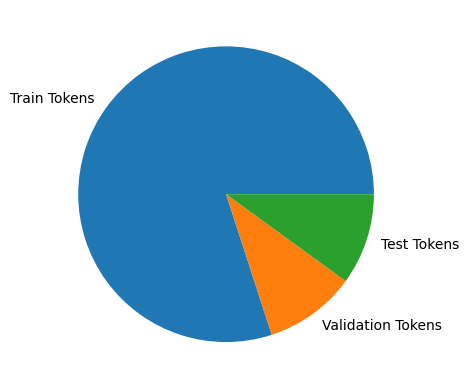

In [10]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

chart = np.array([(train_tt/total_tok), (val_tt/total_tok), (test_tt/total_tok)])
chart_labels = ["Train Tokens", "Validation Tokens", "Test Tokens"]

plt.pie(chart, labels = chart_labels)
plt.show() 

When we calculate the total number of unique tokens, we can see that without lowering the data, we have a lot more words that are considered "unique", even though they are the same word. This is why we have to make all words lowercase.

In [11]:
def get_word_frequency(data_list:list[str]) -> dict:
    word_frequency:dict = {"total_tokens":0, "unique_tokens":0, "unique_token_frequency":{}}
    for value in data_list:
        if value not in word_frequency["unique_token_frequency"].keys():
            word_frequency["unique_token_frequency"][value] = 1
            word_frequency["unique_tokens"] += 1
        else:
            word_frequency["unique_token_frequency"][value] += 1
        word_frequency["total_tokens"] += 1
    return word_frequency

print("Before lower in train dataset unique:",get_word_frequency(flatten_list(train_tokens))["unique_tokens"])
print("After \tlower unique:", get_word_frequency(flatten_list(train_collection.get_token_list()))["unique_tokens"])

Before lower in train dataset unique: 9133
After 	lower unique: 8339


We can also view each of the unique tokens in our frequency list. For now we can print the top 10 most frequent words.

{',': 2268, '(': 1583, ')': 1575, 'the': 1270, '.': 1073, 'of': 1006, 'and': 903, '-': 901, ';': 691, 'in': 639}


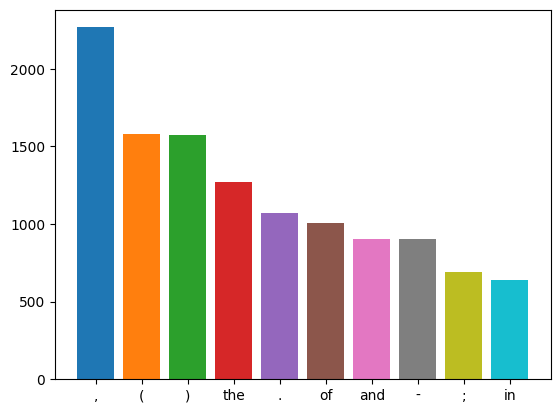

In [12]:
train_frequency:dict = get_word_frequency(flatten_list(train_collection.get_token_list()))
sorted_list = sorted(train_frequency["unique_token_frequency"].items(), key=lambda t: t[1], reverse=True)
sorted_list = sorted_list[:10]
sorted_dict = {item_tuple[0]:item_tuple[1] for item_tuple in sorted_list}
print(sorted_dict)
plt.bar(sorted_dict.keys(), sorted_dict.values(), color=colors)
plt.show() # frequency of classes / labels

From this we can see that the most common words are actually punctuations, rather than words. In the data preprocessing step, we can remove some of these stopwords and see if it improves our accuracy.

Next, let us look at the labels in a given data collection:

{'B-O': 32971, 'B-LF': 1462, 'I-LF': 3231, 'B-AC': 2336}


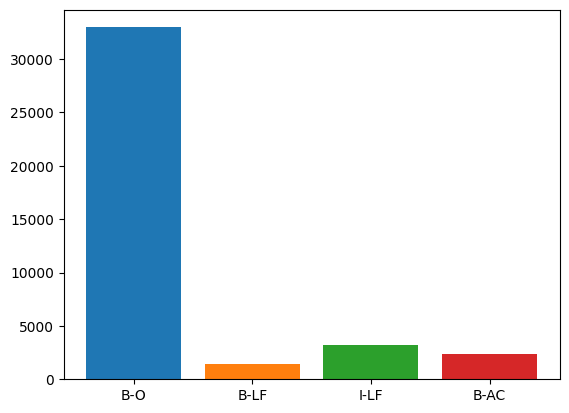

In [13]:
tag_frequency = get_word_frequency(flatten_list(train_collection.get_ner_list()))["unique_token_frequency"]
print(tag_frequency)
plt.bar(tag_frequency.keys(), tag_frequency.values(), color=colors)
plt.show() # frequency of classes / labels

We can see that we have 4 labels, B-O standing for not an abbreviation or long form, B-AC being an abbreviation, B-LF is long form beginning and I-LF is the continuation of the long form. All long forms will be represented as starting with B-LF followed by I-LF if any.

From the plot, we can see that the dataset is imbalanced towards the B-O class. Data imbalance is usually resolved by either oversampling or undersampling the dataset. In the case of oversampling, we would add more values, either from the test or validation set (while removing them from their corresponding set) and adding them to the training set to increase the values of the B-LF, I-LF and B-AC classes. For undersampling we would remove values of B-O. This would be most easily done by removing stop words and their corresponding NER values.

#### Data Pre-processing

Now that we have completed analysing the data, let us start the first experiment by pre-processing and training the data. Firstly, let's look at the first 10 words of the first 5 rows from the training collection:

In [14]:
for tokens in train_tokens[:3]:
    print(tokens[:5])

['For', 'this', 'purpose', 'the', 'Gothenburg']
['The', 'following', 'physiological', 'traits', 'were']
['Minor', 'H', 'antigen', 'alloimmune', 'responses']


We will notice that there are already uppercase tokens here, which would count as "unique" compared to their lowercase counterparts, even though they represent the same words. For this, we will want to lowercase the words in the lists. Luckily, we have already created lowercase lists and loaded this to our collections, so if we look at the rows there we will note that all the letters are uniform.

In [15]:
for data_item in train_collection.collection[:3]:
    print(data_item.tokens[:5])

['for', 'this', 'purpose', 'the', 'gothenburg']
['the', 'following', 'physiological', 'traits', 'were']
['minor', 'h', 'antigen', 'alloimmune', 'responses']


Now that all of our tokens are lowercase, lets try removing the punctuations from our training corpus:

In [45]:
import string
def remove_values(data_collection:DataCollection, remove_values:list|str) -> DataCollection:
    collection:list[DataRow] = []
    for data_row in data_collection.collection:
        new_row:DataRow = DataRow([], [], [])
        for item_idx, token in enumerate(data_row.tokens):
            if token not in remove_values:
                new_row.tokens.append(data_row.tokens[item_idx])
                new_row.pos.append(data_row.pos[item_idx])
                new_row.ner.append(data_row.ner[item_idx])
        if len(new_row.tokens) > 0:
            collection.append(new_row)
    return DataCollection(collection)

print("Token number Before punctuation remove:", len(flatten_list(train_collection.get_token_list())), "| NER len:", len(flatten_list(train_collection.get_ner_list())))
train_collection_no_punct = remove_values(train_collection, string.punctuation)
print("Token number After punctuation remove:", len(flatten_list(train_collection_no_punct.get_token_list())), "| NER len:", len(flatten_list(train_collection_no_punct.get_ner_list())))


Token number Before punctuation remove: 40000 | NER len: 40000
Token number After punctuation remove: 30582 | NER len: 30582


With the punctuations removed, we are left with 30582 tokens. Let's now also remove the stopwords. We can get stopwords from the NLTK library.

In [29]:

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words:list[str] = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
train_collection_no_stopwords = remove_values(train_collection, stop_words)

print("Token number Before stopword remove:", len(flatten_list(train_collection.get_token_list())), "| NER len:", len(flatten_list(train_collection.get_ner_list())))
print("Token number After stopword remove:", len(flatten_list(train_collection_no_stopwords.get_token_list())), "| NER len:", len(flatten_list(train_collection_no_stopwords.get_ner_list())))

punct_and_stop:list[str] = list(stop_words)
punct_and_stop += [*string.punctuation]

train_collection_all_removed = remove_values(train_collection, punct_and_stop)

print("Token number After all remove:", len(flatten_list(train_collection_all_removed.get_token_list())), "| NER len:", len(flatten_list(train_collection_all_removed.get_ner_list())))


Token number Before stopword remove: 40000 | NER len: 40000
Token number After stopword remove: 31497 | NER len: 31497
Token number After all remove: 22079 | NER len: 22079


If we remove the stopwords we are left with 31497 tokens. Removing both the stopwords and punctuations leaves us with 22079 words. But what if we were to also only keep unique tokens? We would lose sequential data (as this would not always guarantee B-LF to be followed by I-LF) and we would expect to have worse results in recognition, but to test this out, let us only keep unique words and then also remove stopwords and punctuations.

In [44]:
def unique_collection(data_collection:DataCollection) -> DataCollection:
    collection:list[DataRow] = []
    unique_tokens:list[str] = []
    for data_row in data_collection.collection:
        new_row:DataRow = DataRow([], [], [])
        for item_idx, token in enumerate(data_row.tokens):
            if token not in unique_tokens:
                new_row.tokens.append(data_row.tokens[item_idx])
                new_row.pos.append(data_row.pos[item_idx])
                new_row.ner.append(data_row.ner[item_idx])
                unique_tokens.append(token)
        if len(new_row.tokens) > 0:
            collection.append(new_row)
    return DataCollection(collection)

train_collection_unique = unique_collection(train_collection)
train_collection_unique_no_stop_and_punct = remove_values(train_collection_unique, punct_and_stop)

print("Token number in unique:", len(flatten_list(train_collection_unique.get_token_list())), "| NER len:", len(flatten_list(train_collection_unique.get_ner_list())))
print("Token number in unique punct and stop words removed:", len(flatten_list(train_collection_unique_no_stop_and_punct.get_token_list())), "| NER len:", len(flatten_list(train_collection_unique_no_stop_and_punct.get_ner_list())))

Token number in unique: 8339 | NER len: 8339
Token number in unique punct and stop words removed: 8198 | NER len: 8198


While we have lost a lot of data, going from 40000 tokens to 8198 is certainly a lot less tokens to train on and thus can reduce the time to train. We will observe how this affects accuracy once we train our model.

When we train, we can use the original collection of tokens, cleaned of punctuations tokens and only unique tokens